# Assignment: SVD Preprocessing on MNIST with Logistic Regression

## Instructions:
In this assignment, you will apply **Singular Value Decomposition (SVD)** as a preprocessing step to the **MNIST dataset** and train a **logistic regression classifier**. You will compare the model performance and training time when using different levels of SVD for dimensionality reduction.

In this assignment, you will need to:
1. Load the MNIST dataset and normalize it.
2. Perform SVD and reduce the dimensions of the data.
3. Train a logistic regression model on the original and SVD-reduced data.
4. Measure and compare the training time and accuracy of the model with varying SVD components.
5. Plot the results and analyze how SVD impacts the performance and efficiency of the model.

***
Your tasks include:
1. Implement SVD algorithm. You are not allowed to directly use SVD implemented by other packages, but you may use functions in NumPy. (Part 2)
2. Explore the accuracy and time performance from different numbers of SVD components. (Part 4)
3. Visualize the accuracy, time performance and top 5 singular vectors in the dataset, analyze and explain which number of SVD component looks best to you? (Part 4,5&6) Hint: singular vectors should be reshaped to 28x28 images for visualization.
***
**Note that you may not import any other function or package.** Let's get started!


## Part 1: Load the MNIST dataset and preprocess the data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score, classification_report

# Load MNIST dataset
print("Loading MNIST dataset...")
mnist = fetch_openml('mnist_784', version=1)
X = mnist.data
y = mnist.target

# Normalize the data
X = X / 255.0

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Loading MNIST dataset...


## Part 2: Implement SVD for Dimensionality Reduction

In [2]:
import numpy as np

def manual_svd(X):
    # Step 1: Compute X^T X
    xtx = np.dot(X.T, X)
    
    # Step 2: Eigenvalue decomposition of X^T X to get V and singular values squared
    eigenvalues, v = np.linalg.eig(xtx)
    
    # Discard any imaginary part that might result from numerical issues
    eigenvalues = np.real(eigenvalues)
    v = np.real(v)
    
    # Clamp negative eigenvalues to zero to avoid issues with sqrt
    eigenvalues[eigenvalues < 0] = 0
    
    # Sort the eigenvalues and corresponding eigenvectors in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    v = v[:, sorted_indices]
    
    # Step 3: The singular values are the square roots of the non-negative eigenvalues
    singular_values = np.sqrt(eigenvalues)
    
    # Avoid division by zero by replacing very small singular values with a small threshold
    eps = 1e-10  # Small value to avoid division by zero
    singular_values[singular_values < eps] = eps
    
    # Step 4: Compute U = X V / Sigma
    u = np.dot(X, v)
    u /= singular_values  # Normalize each column by its corresponding singular value
    
    # Return U, singular values (as a vector), and V^T
    vt = v.T
    
    return u, singular_values, vt


In [8]:
def apply_svd_custom(X_train, X_test, n_components):

    # standardize the data since large scale differences can dominate variance and allow for better interperatation of data
    X_train_mean = np.mean(X_train, axis=0)
    X_train_std = np.std(X_train, axis=0)
    X_train_std[X_train_std == 0] = 1 # incase div by 0

    X_train_stdized= (X_train - X_train_mean) / X_train_std
    X_test_stdized = (X_test - X_train_mean) / X_train_std

    u, s, vt = manual_svd(X_train_stdized)
    # u, s, vt = np.linalg.svd(X_train_stdized, full_matrices=False)

    # saves first n components to redice dimensions
    u_comp = u[:, :n_components]
    s_comp = s[:n_components]
    vt_comp = vt[:n_components, :]


    #
    # reconstruct the train data set after dimeinsion reduction using u since same rows 
    X_train_reduced = np.dot(u_comp, np.diag(s_comp))

    # Project the test data into the same space using Vt_k since we are working with new rows
    #  but vt_k tells us about the columns of the training set so by taking the transpose
    # we are able to project into the lower dimension 
    X_test_reduced = np.dot(X_test_stdized, vt_comp.T)

    return X_train_reduced, X_test_reduced, vt_comp

In [4]:
# SVD components to test
n_components = 7  # For example, reduce to 7 components

# Apply SVD to the training and test sets
X_train_svd, X_test_svd = apply_svd_custom(X_train, X_test, n_components)

# Check the shapes to ensure consistency
print("Shape of X_train_svd:", X_train_svd.shape)  # Should be (n_samples_train, n_components)
print("Shape of X_test_svd:", X_test_svd.shape)    # Should be (n_samples_test, n_components)

Shape of X_train_svd: (56000, 7)
Shape of X_test_svd: (14000, 7)


## Part 3: Train Logistic Regression and Measure Performance

In [5]:
# Function to train logistic regression and track training time
def train_logistic_regression(X_train, y_train, X_test, y_test):
    model = LogisticRegression(max_iter=1000, solver='saga', random_state=42, multi_class='multinomial')
    
    # Measure training time
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy, training_time


## Part 4: Experiment with Different Levels of SVD

Now, apply SVD with varying numbers of components and observe how the dimensionality reduction impacts the model's performance. Record both the accuracy and training time for each number of components.


In [9]:
svd_components = [7, 14, 28, 56, 112]  # You can modify these as needed

# Store the results and right singular vectors
results = []
vt_results = []  # Store V^T for later visualization

print("Training models with different levels of SVD preprocessing...")
for n_components in svd_components:
    print(f"Applying custom SVD with {n_components} components...")
    
    X_train_svd, X_test_svd, vt = apply_svd_custom(X_train, X_test, n_components)

    # Train the logistic regression model and get accuracy and training time
    accuracy, training_time = train_logistic_regression(X_train_svd, y_train, X_test_svd, y_test)

    results.append((n_components, accuracy, training_time))
    vt_results.append(vt) 
    
    print(f"SVD components: {n_components}, Accuracy: {accuracy:.4f}, Training time: {training_time:.4f} seconds")

# Convert results to a NumPy array for easier manipulation
results = np.array(results)

Training models with different levels of SVD preprocessing...
Applying custom SVD with 7 components...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SVD components: 7, Accuracy: 0.7460, Training time: 2.3729 seconds
Applying custom SVD with 14 components...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SVD components: 14, Accuracy: 0.8371, Training time: 10.6209 seconds
Applying custom SVD with 28 components...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


SVD components: 28, Accuracy: 0.8898, Training time: 36.6595 seconds
Applying custom SVD with 56 components...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


SVD components: 56, Accuracy: 0.9069, Training time: 66.2298 seconds
Applying custom SVD with 112 components...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SVD components: 112, Accuracy: 0.9159, Training time: 123.2351 seconds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


## Part 5: Visualize and Analyze the Results

Finally, plot the accuracy, training time as a function of the number of SVD components, and top 5 singular vectors. This will help you understand the trade-off between dimensionality reduction, accuracy, and model training time, and how SVD generally works. Hint: singular vectors should be reshaped to 28x28 images for visualization.


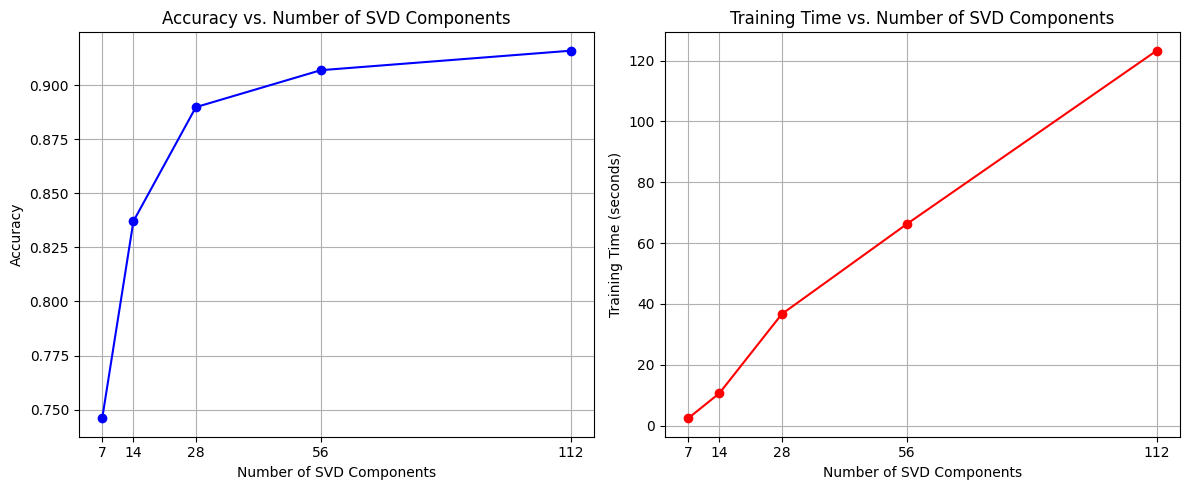

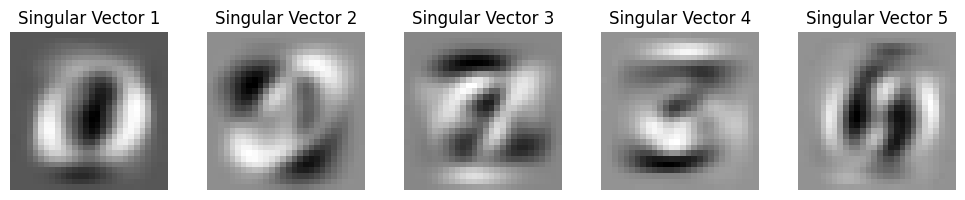

In [12]:
import matplotlib.pyplot as plt

# Plotting the accuracy and training time
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(results[:, 0], results[:, 1], marker='o', linestyle='-', color='b')
plt.xlabel('Number of SVD Components')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of SVD Components')
plt.xticks(results[:, 0])  # Set x-ticks to the component values
plt.grid(True)

# Plot training time
plt.subplot(1, 2, 2)
plt.plot(results[:, 0], results[:, 2], marker='o', linestyle='-', color='r')
plt.xlabel('Number of SVD Components')
plt.ylabel('Training Time (seconds)')
plt.title('Training Time vs. Number of SVD Components')
plt.xticks(results[:, 0])  # Set x-ticks to the component values
plt.grid(True)

plt.tight_layout()
plt.show()

# Visualizing the Top 5 Singular Vectors
def visualize_singular_vectors(vt, num_vectors=5):
    plt.figure(figsize=(10, 2))

    for i in range(num_vectors):
        singular_vector = vt[i, :].reshape(28, 28)  # Reshape into a 28x28 image
        
        plt.subplot(1, num_vectors, i + 1)
        plt.imshow(singular_vector, cmap='gray')
        plt.axis('off')
        plt.title(f'Singular Vector {i + 1}')
    
    plt.tight_layout()
    plt.show()

# Visualize the top 5 singular vectors from the last SVD applied (using the last vt stored)
visualize_singular_vectors(vt_results[-1], num_vectors=5)  # Get the last V^T for visualization


## Part 6: Analyze / Conclusion 

YOUR ANSWER: 

The accuracy plot demonstrates a stable performance above 0.90 with around 14 components, indicating that a relatively low number of components can capture the majority of the useful information for classification. Conversely, the training time plot shows a notable increase as the number of components rises showing the compromise for accuracy and computational efficiency. I did test it for 700 components and it finished running after aobut 50 min and the accuracy was not much better than it was for 112 componments (i reset the notbook so i lost the data and not willing to do it again :o). THis also shows the imporance of finding an optimal balanance for practical use.The visualized singular vectors, which represent averaged features of the digits. What is cool is that this we are able to make out numbers from the vt matrix which captures the most variance. Overall, the analysis highlights the efficiency of SVD in simplifying the model while maintaining high accuracy, making it a valuable technique for handling complex datasets like MNIST.






